**First Step is to generate white noise process with random seed to ensure reproductibility**

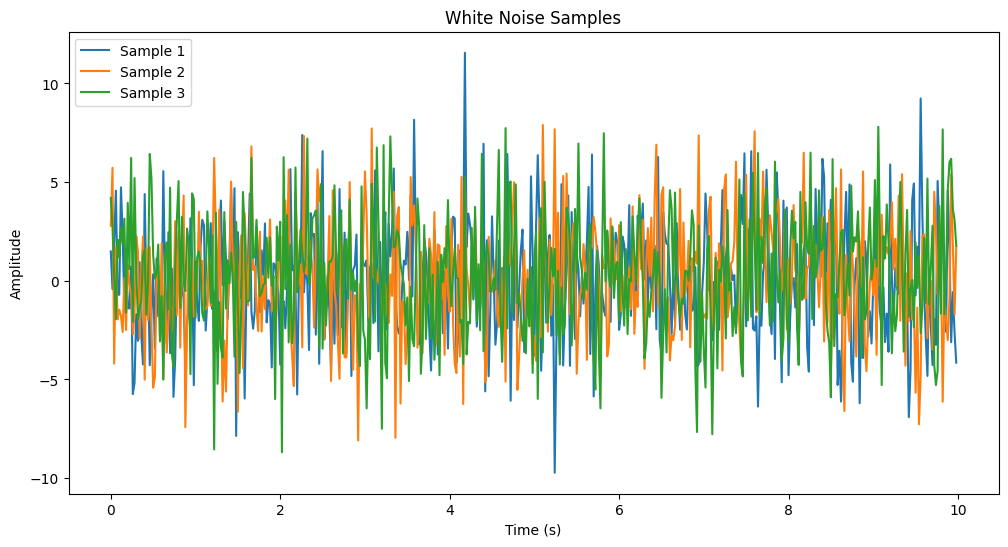

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
mean = 0
std_dev = 3.0
time_step = 0.02
duration = 10
num_samples = 50
random_seed = 42  # Set a random seed for reproducibility

# Set the random seed
np.random.seed(random_seed)

# Time array
time = np.arange(0, duration, time_step)

# Generate white noise samples
white_noise_samples = [np.random.normal(mean, std_dev, len(time)) for _ in range(num_samples)]

# Plot a few samples
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(time, white_noise_samples[i], label=f'Sample {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('White Noise Samples')
plt.legend()
plt.show()


**First let's define some basics of the system**

In [2]:
m=1
k=1
c=0.02
a=0.5
beta= 0.5
A=1
gamma= 0.5
n=5
# a= 0.2 #post yield-ratio

**Let's solve equation by Runge-kutta Scheme**

In [3]:
#initialize variables
u= np.zeros((num_samples,len(time)))
vu= np.zeros((num_samples,len(time)))
z= np.zeros((num_samples,len(time)))
F= np.array(white_noise_samples)


In [4]:
u.shape

(50, 500)

In [5]:
F.shape

(50, 500)

In [6]:
def v_func(Fi,c,ui,vi,a,k,zi,m):
    return (Fi-c*vi-a*k*ui-(1-a)*k*zi)/m
def z_func(A,beta,gamma, vi,ui, zi,n):
    return A*vi-beta*abs(vi)*pow(abs(zi),n-1)*zi- gamma*vi*pow(abs(zi),n)

In [7]:
"""
Using Runge-kutta scheme, I evaluated the values of next u,v, and z as follows.
While I had difficulty finding out what must be the logical thing to do with Force, and z term calculating k1, k2,k3,k4, I choose mean of F in middle steps
and z is calculated simultaenously. I will be waiting for your feedback and possibly, resources if you have any.
"""


def func(ui,vi,zi,Fi,Fi1, m,c,k,a,A,beta,gamma,n):
    k1u= vi
    k1v= v_func(Fi,c,ui,vi,a,k,zi,m)
    k1z= z_func(A,beta,gamma,vi,ui,zi,n)
    k2u = vi+k1v*time_step/2
    k2v =v_func((Fi1+Fi)/2,c,ui+k1u*time_step/2, vi+k1v*time_step/2,a ,k ,zi+k1z*time_step/2, m)
    k2z = z_func(A,beta, gamma, vi+k1v*time_step/2, ui+k1u*time_step/2, zi+k1z*time_step/2,n)
    k3u = vi+k2v*time_step/2
    k3v =v_func((Fi1+Fi)/2,c,ui+k2u*time_step/2, vi+k2v*time_step/2,a ,k ,zi+k2z*time_step/2, m)
    k3z = z_func(A,beta, gamma, vi+k2v*time_step/2, ui+k2u*time_step/2, zi+k2z*time_step/2,n)
    k4u = vi+k3v*time_step
    k4v =v_func(Fi1,c,ui+k3u*time_step, vi+k3v*time_step,a ,k ,zi+k3z*time_step, m)
    k4z = z_func(A,beta, gamma, vi+k3v*time_step, ui+k3u*time_step, zi+k3z*time_step,n)
    ui1= ui + time_step* (k1u+ 2*k2u + 2*k3u +k4u)/6
    vi1= vi + time_step* (k1v+ 2*k2v + 2*k3v +k4v)/6
    zi1= zi + time_step* (k1z+ 2*k2z + 2*k3z +k4z)/6
    return ui1, vi1, zi1

In [8]:
for j in range(50): 
    for i in range(1,len(time),1):
        u[j][i], vu[j][i], z[j][i]= func(u[j][i-1],vu[j][i-1],z[j][i-1],F[j][i-1],F[j][i],m,c,k,a,A,beta,gamma,n)


Text(0, 0.5, 'Displacement (u)')

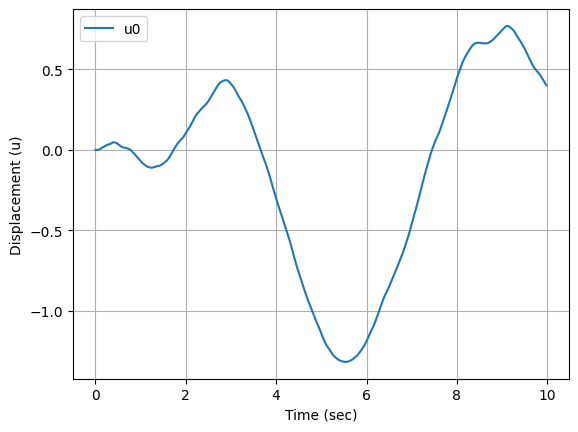

In [9]:
# range = np.arange(0,500,1)

# plt.plot(range,u[0])
# plt.plot(time, u[1])
plt.plot(time, u[49])
plt.grid(True)
plt.legend(["u0","u1","u2"])
plt.xlabel("Time (sec)")
plt.ylabel("Displacement (u)")

In [10]:
u.shape[0]

50

In [11]:
u.shape[1]

500

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [13]:
# Assuming force_data and displacement_data are your numpy arrays
force_data = F.copy()  # Replace with your file path
displacement_data = u.copy()  # Replace with your file path



In [14]:
X_temp, X_test, y_temp, y_test = train_test_split(force_data, displacement_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [15]:
# Scale data
scaler_X = MinMaxScaler(feature_range=(-1, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))



# Flatten for scaling
X_train_flattened = X_train.reshape(-1, 1)  
y_train_flattened = y_train.reshape(-1, 1)  

scaler_X.fit(X_train_flattened)
scaler_y.fit(y_train_flattened)

# Scale the data
X_train_scaled = scaler_X.transform(X_train_flattened)  # Shape: (25000, 1)
y_train_scaled = scaler_y.transform(y_train_flattened)  # Shape: (25000, 1)

# Reshape back to original dimensions
X_train_scaled = X_train_scaled.reshape(X_train.shape)  
y_train_scaled = y_train_scaled.reshape(y_train.shape)  


"""
Scaling of the test data
"""

# Flatten for scaling
X_test_flattened = X_test.reshape(-1, 1)  
y_test_flattened = y_test.reshape(-1, 1)  

# Scale the data
X_test_scaled = scaler_X.transform(X_test_flattened)  # Shape: (25000, 1)
y_test_scaled = scaler_y.transform(y_test_flattened)  # Shape: (25000, 1)

# Reshape back to original dimensions
X_test_scaled = X_test_scaled.reshape(X_test.shape)  
y_test_scaled = y_test_scaled.reshape(y_test.shape)  


"""
Scaling for Validation data
"""


# Flatten for scaling
X_val_flattened = X_val.reshape(-1, 1)  
y_val_flattened = y_val.reshape(-1, 1)  

# Scale the data
X_val_scaled = scaler_X.transform(X_val_flattened)  # Shape: (25000, 1)
y_val_scaled = scaler_y.transform(y_val_flattened)  # Shape: (25000, 1)

# Reshape back to original dimensions
X_val_scaled = X_val_scaled.reshape(X_val.shape)  
y_val_scaled = y_val_scaled.reshape(y_val.shape)  


# Verify shapes
print(f"Force scaled shape: {X_train_scaled.shape}")
print(f"Displacement scaled shape: {y_train_scaled.shape}")

Force scaled shape: (30, 500)
Displacement scaled shape: (30, 500)


In [16]:
X_train_LSTM = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_val_LSTM = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
y_train_LSTM = y_train_scaled.reshape((y_train_scaled.shape[0], y_train_scaled.shape[1], 1))
y_val_LSTM = y_val_scaled.reshape((y_val_scaled.shape[0], y_val_scaled.shape[1], 1))

In [17]:
X_train_LSTM.shape

(30, 500, 1)

In [18]:
X_train_scaled.shape

(30, 500)

In [42]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model.add(Activation('relu'))
model.add(LSTM(100, return_sequences=True))
model.add(Activation('relu'))
model.add(Dense(1))  # Assuming single output feature for displacement

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mse'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 500, 100)          40800     
                                                                 
 activation_4 (Activation)   (None, 500, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 500, 100)          80400     
                                                                 
 activation_5 (Activation)   (None, 500, 100)          0         
                                                                 
 dense_2 (Dense)             (None, 500, 1)            101       
                                                                 
Total params: 121301 (473.83 KB)
Trainable params: 121301 (473.83 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
history = model.fit(X_train_LSTM, y_train_scaled, epochs=500, batch_size=20, validation_data=(X_val_LSTM, y_val_scaled), shuffle=True)

Epoch 1/500
2/2 [==============================] - 8s 2s/step - loss: 0.1162 - mse: 0.1162 - val_loss: 0.1105 - val_mse: 0.1105
Epoch 2/500
2/2 [==============================] - 1s 526ms/step - loss: 0.1079 - mse: 0.1079 - val_loss: 0.0999 - val_mse: 0.0999
Epoch 3/500
2/2 [==============================] - 1s 527ms/step - loss: 0.0977 - mse: 0.0977 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 4/500
2/2 [==============================] - 1s 530ms/step - loss: 0.0994 - mse: 0.0994 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 5/500
2/2 [==============================] - 1s 566ms/step - loss: 0.0980 - mse: 0.0980 - val_loss: 0.0911 - val_mse: 0.0911
Epoch 6/500
2/2 [==============================] - 1s 504ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0916 - val_mse: 0.0916
Epoch 7/500
2/2 [==============================] - 1s 541ms/step - loss: 0.0926 - mse: 0.0926 - val_loss: 0.0921 - val_mse: 0.0921
Epoch 8/500
2/2 [==============================] - 1s 583ms/step - loss: 0.0930 - mse:

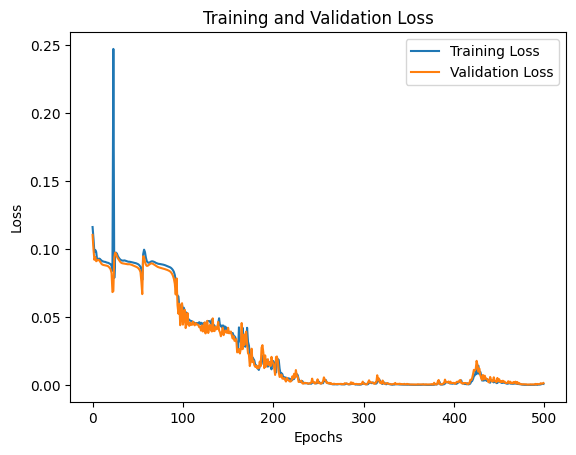

In [45]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Loss_fig_nowindow.jpg")
plt.show()

In [55]:
model.save("Model_LSTM_Noslide.h5")

C:\Users\acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
X_test_LSTM = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [47]:
test_loss = model.evaluate(X_test_LSTM, y_test_scaled)
y_pred = model.predict(X_test_scaled)

# Inverse transform predictions to original scale
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1))

1/1 [==============================] - 1s 599ms/step


In [48]:
y_pred_inverse = y_pred_inverse.reshape(y_test.shape)
y_test_inverse = y_test_inverse.reshape(y_test.shape)

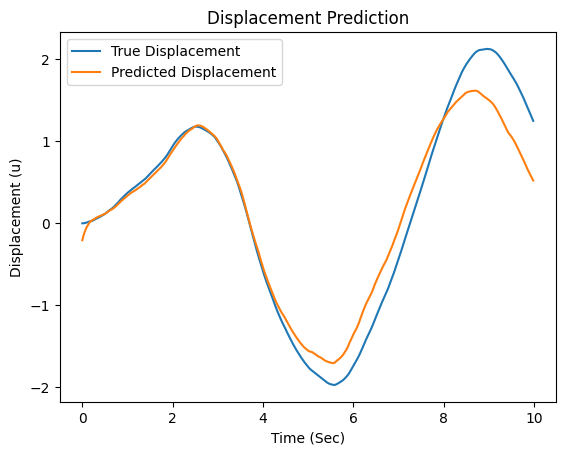

In [58]:
plt.figure()
plt.plot(time,y_test_inverse[3], label='True Displacement')
plt.plot(time,y_pred_inverse[3], label='Predicted Displacement')
plt.title('Displacement Prediction')
plt.legend()
plt.xlabel("Time (Sec)")
plt.ylabel("Displacement (u)")
# plt.savefig("DispPrediction_nowindow.jpg")
plt.show()

In [50]:
y_pred_inverse.shape

(10, 500)

In [51]:
len(y_pred_inverse)

10

In [52]:
ymaxpredict= np.zeros(len(y_pred_inverse))
ymaxtest = np.zeros(len(y_test_inverse))
for i in range(len(y_pred_inverse)):
    ymaxpredict[i] = max(abs(y_pred_inverse[i]))
    ymaxtest[i] = max(abs(y_test_inverse[i]))

In [53]:
samples = np.arange(0,10,1)
samples

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

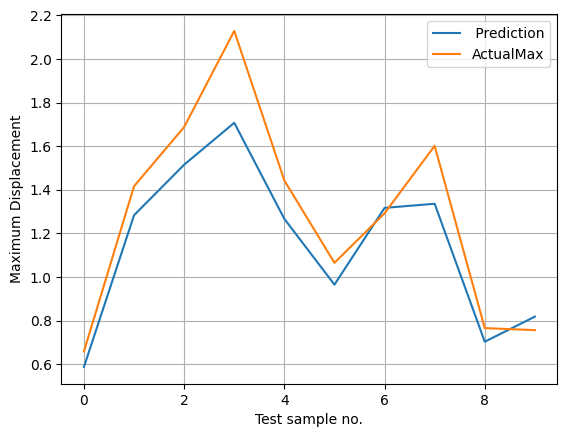

In [56]:
plt.plot(samples, ymaxpredict, label= " Prediction")
plt.plot(samples, ymaxtest, label = "ActualMax")
plt.legend()
plt.grid(True)
plt.xlabel("Test sample no.")
plt.ylabel("Maximum Displacement")
plt.savefig("Truemax_VS_predmax")
plt.show()